In [1]:
import gzip
from itertools import islice

# Formats de fichiers

## FASTA

Le fichier FASTA contient des séquences identifiées et annotés brièvement par une description.

```
>ID DESCRIPTION
SEQUENCE
```

In [2]:
with gzip.open('GCF_000002985.6_WBcel235_rna.fna.gz', 'rt') as f:
    print(f.readline())
    print(f.readline())

>NM_001025782.2 Caenorhabditis elegans Phosphatidylinositol 3-kinase catalytic subunit type 3 (vps-34), partial mRNA

ATGCGAGTCTCCACGTCAGTCAACGGTGGTGTTGGGATTGTTTCGGCCTGTACCCGTTACTGTGTAGCTGATCCTGAACT



In [3]:
def read_fasta(path):
    with gzip.open(path, 'rt') as f:
        accession, description, seq = None, None, None
        for line in f:
            if line[0] == '>':
                # yield current record
                if accession is not None:
                    yield accession, description, seq
                    
                # start a new record
                accession, description = line[1:].rstrip().split(maxsplit=1)
                seq = ''
            else:
                seq += line.rstrip()

In [4]:
next(read_fasta('GCF_000002985.6_WBcel235_rna.fna.gz'))

('NM_001025782.2',
 'Caenorhabditis elegans Phosphatidylinositol 3-kinase catalytic subunit type 3 (vps-34), partial mRNA',
 'ATGCGAGTCTCCACGTCAGTCAACGGTGGTGTTGGGATTGTTTCGGCCTGTACCCGTTACTGTGTAGCTGATCCTGAACTTCTTCTAGAATCTCTGGCGGAAGTTAAACACAGTGCAATGACACGTCGAATCAGAGATGTTGAAGATGAGAGACATCGACAAGTAAAACCGAATAAACAAGCAAAGGATCGATTGGAGACTATTGTGAATCTTCCATCATCTCAAGTTCTTACAAGAGAACAAAGAGATTTAGTATGGAAATTCAGGCATTATTTAAGACAATTTCCAAAAGCTTTGAACAAATATCTACGATCAGTTAATTGGGTTCATCCACAAGAAGTAAAAACTGCATTAGCTCTGATGAATGATTGGGAGCTGATTGAAGCTGAAGATGCATTAGAATTACTTTCAAGTGCATTCACTCATCCGGCAGTTCGTGCATATTCTGTATCCCGTCTTCTAGAAGCTGCTTCTCCTGAGCAAGTCCTCCTATATCTTCCACAATTGGTTCAAGCTTTGAAATACGAACAAGGTCAACAACTGCCTGAAGAAGGAAATCCAGTGCCGGTGGTTTCTGAAGAAGAGGGAAAGATCCCATCAGTTGCAACTACGCCAACTGAAGAGCTAGAAGGACGAGATATGACAGTGGTTACGAAGAAAGAGGCTAGAAAGGCGGCTAGTGGAGATTTGGCCACCTTCCTGATTGACTATGCTCTTGCATCTCCAAAAGTATCCAACTATCTCTACTGGCATCTAAAAACTGAAATTGAATCAACAAAAGAAAGTAAAGAAGAACACTCGAAAATGTATCAAAATATCCAGGATAGATTGATGGAAGCACTTGTAAAGAGACCTGATACCCGTGCACAAGTTG

## FASTQ

Le format FASTQ contient des fragments annotés avec une qualité pour chaque symboles lus par le système de séquençage.

```
@SEQID DESCRIPTION
SEQUENCE
+
QUALITY
```

In [5]:
with gzip.open('reads.fastq.gz', 'rt') as f:
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())

@SLFZSLQY <unknown description>

GTGAAGTTGAGAGGAGGAGATGAGATTACCTATGATTATATGGTTATTGCCATGGGCGTTCAGTTGAGATATGATATGATCAAAGGAGCAAAAGAGGCTC

+

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [6]:
def read_fastq(path):
    with gzip.open(path, 'rt') as f:
        for line in f:
            seqid, description = line[1:].rstrip().split(maxsplit=1)
            sequence = f.readline().rstrip()
            _ = f.readline()
            quality = f.readline().rstrip()
            yield seqid, description, sequence, quality

In [7]:
next(read_fastq('reads.fastq.gz'))

('SLFZSLQY',
 '<unknown description>',
 'GTGAAGTTGAGAGGAGGAGATGAGATTACCTATGATTATATGGTTATTGCCATGGGCGTTCAGTTGAGATATGATATGATCAAAGGAGCAAAAGAGGCTC',
 '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [8]:
%%time
for _ in read_fastq('reads.fastq.gz'):
    pass

CPU times: user 292 ms, sys: 3.26 ms, total: 295 ms
Wall time: 294 ms


## BED

Le format BED est un format tabulaire de 3 à 12 colonnes qui contient des annotations de sous-séquences.

```
reference    start    end    name
```

Dans ce TP, nous utiliserons seulement les 4 premières colonnes pour identifier la référence, une paire de coordonnées `(début, fin)` et l'identifiant du contig assemblé depuis notre graphe de Brujin.

In [9]:
def read_bed(path):
    with open(path) as f:
        ref, start, end, name = f.readline().rstrip().split('\t')
        yield ref, int(start) - 1, int(end), name

In [10]:
next(read_bed('example.bed'))

('NM_001025782.2', 1484, 1584, 'GWFGBLMN')

# Notions de base et algorithmes

In [11]:
seq = next(read_fasta('GCF_000002985.6_WBcel235_rna.fna.gz'))[2]
l = len(seq)
seq[:30]

'ATGCGAGTCTCCACGTCAGTCAACGGTGGT'

# $k$-mer

Sous-séquence de longueur $k$. Une chaîne de longueur $l$ possède $l - k + 1$ $k$-mers.

In [12]:
k = 21
kmers = [seq[i:i+k] for i in range(l - k + 1)]

In [13]:
for i, km in enumerate(kmers[:10]):
    print((i * ' ') + km)

ATGCGAGTCTCCACGTCAGTC
 TGCGAGTCTCCACGTCAGTCA
  GCGAGTCTCCACGTCAGTCAA
   CGAGTCTCCACGTCAGTCAAC
    GAGTCTCCACGTCAGTCAACG
     AGTCTCCACGTCAGTCAACGG
      GTCTCCACGTCAGTCAACGGT
       TCTCCACGTCAGTCAACGGTG
        CTCCACGTCAGTCAACGGTGG
         TCCACGTCAGTCAACGGTGGT


# Graphe de Brujin

Les sommets sont les $k$-mers et les arcs sont les transition sur un symbole de l'aphabet.

In [14]:
seq[:10+k]

'ATGCGAGTCTCCACGTCAGTCAACGGTGGTG'

In [15]:
k = 7
kmers = [seq[i:i+k] for i in range(l - k + 1)]

def edges(kmers_graph):
    for k in kmers_graph:
        for s in 'ATCG':
            successor = k[1:] + s
            if successor in kmers_graph:
                yield k, successor
                
for v1, v2 in islice(edges(set(kmers[:10])), 10):
    print(v1, v2, 'transition on {}'.format(v2[-1]))

CGAGTCT GAGTCTC transition on C
GTCTCCA TCTCCAC transition on C
AGTCTCC GTCTCCA transition on A
GAGTCTC AGTCTCC transition on C
GCGAGTC CGAGTCT transition on T
ATGCGAG TGCGAGT transition on T
CTCCACG TCCACGT transition on T
TCTCCAC CTCCACG transition on G
TGCGAGT GCGAGTC transition on C


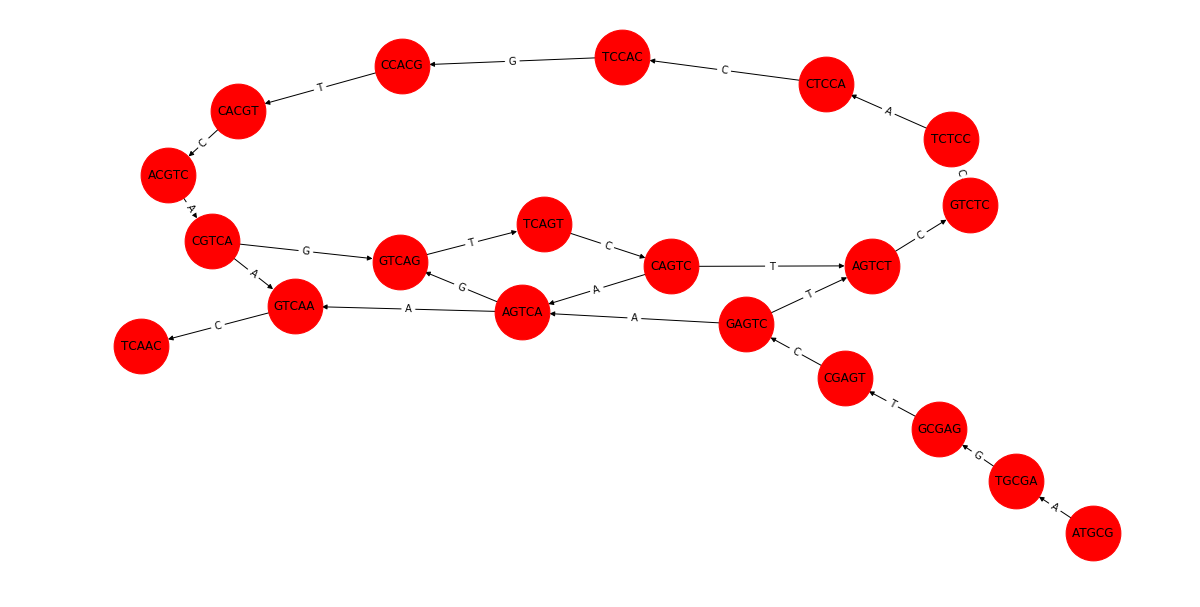

In [16]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

k = 5
kmers = [seq[i:i+k] for i in range(l - k + 1)]

plt.figure(figsize=(16,8))
g = nx.DiGraph()
g.add_nodes_from(set(kmers[:20]))
g.add_edges_from((u, v, {'label': v[-1]}) for u, v in edges(set(kmers[:20])))
nx.draw(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), with_labels=True, node_size=3000)
nx.draw_networkx_edge_labels(g, pos=nx.drawing.nx_agraph.graphviz_layout(g), edge_labels=nx.get_edge_attributes(g, 'label'))
plt.show()

# $k$-mer walk

Lorsque vous traverserez votre graphe, vous devrez adapter cette technique puisqu'il pourra exister plusieurs candidats potentiels et il sera également possible de revenir sur ses pas (i.e. une boucle).

In [17]:
def kmer_walk(kmer_graph, start):
    k = start
    
    # yield the starting node
    yield k
    
    while True:
        for symbol in ['A', 'T', 'C', 'G']:
            candidate = k[1:] + symbol
            if candidate in kmer_graph:
                k = candidate
                yield k
                break
        else:
            break # break the while-loop if no more candidate is found

In [18]:
k = 21
kmers = [seq[i:i+k] for i in range(l - k + 1)]

kmer_graph = set(kmers)
contig = None

for k in islice(kmer_walk(kmer_graph, start='GATGCATTAGAATTACTTTCA'), 20):
    if contig is None:
        contig = k
    else:
        contig += k[-1]
    print(((len(contig) - len(k)) * ' ') + k)
print(contig)

GATGCATTAGAATTACTTTCA
 ATGCATTAGAATTACTTTCAA
  TGCATTAGAATTACTTTCAAG
   GCATTAGAATTACTTTCAAGT
    CATTAGAATTACTTTCAAGTG
     ATTAGAATTACTTTCAAGTGC
      TTAGAATTACTTTCAAGTGCA
       TAGAATTACTTTCAAGTGCAT
        AGAATTACTTTCAAGTGCATT
         GAATTACTTTCAAGTGCATTC
          AATTACTTTCAAGTGCATTCA
           ATTACTTTCAAGTGCATTCAC
            TTACTTTCAAGTGCATTCACT
             TACTTTCAAGTGCATTCACTC
              ACTTTCAAGTGCATTCACTCA
               CTTTCAAGTGCATTCACTCAT
                TTTCAAGTGCATTCACTCATC
                 TTCAAGTGCATTCACTCATCC
                  TCAAGTGCATTCACTCATCCG
                   CAAGTGCATTCACTCATCCGG
GATGCATTAGAATTACTTTCAAGTGCATTCACTCATCCGG


In [19]:
print(seq[seq.find(contig)-10:seq.find(contig)+110])
print(10 * ' ' + contig)

TGAAGCTGAAGATGCATTAGAATTACTTTCAAGTGCATTCACTCATCCGGCAGTTCGTGCATATTCTGTATCCCGTCTTCTAGAAGCTGCTTCTCCTGAGCAAGTCCTCCTATATCTTCC
          GATGCATTAGAATTACTTTCAAGTGCATTCACTCATCCGG


# Exemple de cycle

La solution générale pour un cycle est de mémoriser les endroits déjà visité du graphe et d'interrompre le parcours.

In [20]:
k = 6
kmers = [seq[i:i+k] for i in range(l - k + 1)]

contig = None
closed = set()

for k in islice(kmer_walk(kmers, start='GATGCA'), 40):
    if contig is None:
        contig = k
    else:
        contig += k[-1]
        
    print(((len(contig) - len(k)) * ' ') + k, 'already visited!' if k in closed else '')
        
    if k in closed:
        break # stop traversal on repeat
    else:
        closed.add(k)

print(contig)

GATGCA 
 ATGCAA 
  TGCAAA 
   GCAAAA 
    CAAAAA 
     AAAAAT 
      AAAATA 
       AAATAT 
        AATATA 
         ATATAC 
          TATACA 
           ATACAA 
            TACAAA 
             ACAAAA 
              CAAAAA already visited!
GATGCAAAAATATACAAAAA


# Produire des identifiants aléatoires

In [21]:
# Identifiant aléatoire
import random
import string
random.seed(123) # recommendé pour des résultats reproduisibles!
''.join(random.choices(string.ascii_uppercase, k=10))

'BCKCXANIWE'